# PROJECT

**NOME:** Christian

**COGNOME:** Uccheddu

**MATRICOLA:** 800428

> This project is based on the code of Prof. Samuel Albani left during the lessons.

Voglio usare questi due dataset

https://crudata.uea.ac.uk/cru/data/temperature/#datdow

In particolare

CRUTEM5, HadSST4

First the necessary libraries are imported in which the relative versions are also printed so that everything is reproducible.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy
import seaborn as sns
import seaborn
from pylab import *
import matplotlib.gridspec as gridspec
from cartopy.util import add_cyclic_point

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib
import cartopy
import xarray as xr

pd.options.mode.chained_assignment = None

print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)
print("Cartopy version:",cartopy.__version__)
print("Geoandas version:",gpd.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Scipy version:",scipy.__version__)
print("Seaborn version:",sns.__version__)
print("Xarray version:",xr.__version__)

Pandas version: 1.2.3
Numpy version: 1.19.2
Cartopy version: 0.18.0
Geoandas version: 0.8.1
Matplotlib version: 3.3.4
Scipy version: 1.6.1
Seaborn version: 0.11.1
Xarray version: 0.17.0


In [3]:
model = 'CRUTEM'

In [12]:
modfile0=''.join(['dati/',model,'.5.0.1.0.anomalies.nc'])
#modfile1=''.join(['dati/ts_Amon_',model,'_historical_r1i1p1f1_gn_185001-201412.nc'])

ds0 = xr.open_dataset(modfile0)
#ds1 = xr.open_dataset(modfile1)

ts = ds0.tas
#psl = ds0.psl

In [13]:
ts

<xarray.DataArray 'tas' (time: 2052, latitude: 36, longitude: 72)>
[5318784 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2020-12-16T12:00:00
  * latitude   (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Attributes:
    standard_name:  air_temperature_anomaly
    long_name:      air_temperature_anomaly over land
    units:          K
    cell_methods:   area: mean (interval: 5.0 degrees_north 5.0 degrees_east)...

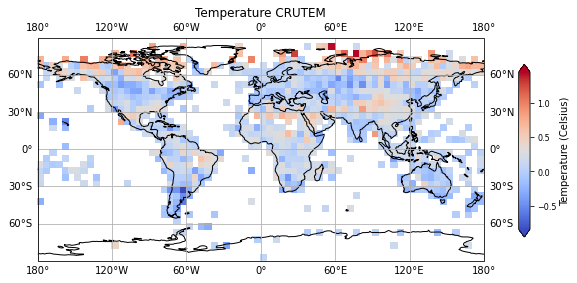

In [25]:
ts_avg_cyc, ts_lon_cyc = add_cyclic_point(ts.mean(axis= 0), coord=ts.longitude)  
fig = plt.figure(figsize = (8,8))
cmap2 = mpl.cm.coolwarm

#norm2 = mpl.colors.Normalize(vmin=-3,vmax=0) 

ax1 = fig.add_subplot(projection=ccrs.PlateCarree())
ax1.set_title('Temperature {}'.format(model))
ax1.set_global()
mm1 = ax1.pcolormesh(ts_lon_cyc, ts.latitude, ts_avg_cyc, \
                   transform=ccrs.PlateCarree(),cmap=cmap2 )  

ax1.coastlines()
ax1.gridlines(draw_labels=True)

#- add colorbar
cbar_ax1 = fig.add_axes([0.96, 0.35, 0.02, 0.30]) #[left, bottom, width, height]
cbar1 = fig.colorbar(mm1, cax=cbar_ax1, extend='both', orientation='vertical')
cbar1.set_label('Temperature (Celsius)')
cbar1.ax.tick_params(labelsize=8)

Vediamolo come serie storica

In [28]:
time_series = ts.groupby('time.year').mean('time')
time_series = time_series.mean(("longitude", "latitude"))

In [31]:
time_series

<xarray.DataArray 'tas' (year: 171)>
array([-0.60566989, -0.22645384, -0.41875832, -0.45257101, -0.08970588,
       -0.71412945, -0.64177991, -0.51506117, -0.44942748, -0.01069277,
       -0.75260035, -0.4101157 , -0.85302305,  0.03291031, -0.83743202,
       -0.41539416, -0.35573256, -0.71122319, -0.30492341, -0.31330768,
       -0.60644164, -0.82724077, -0.21348237, -0.36998077, -0.32826259,
       -0.91730006, -0.57954616, -0.33428992,  0.0911432 , -0.56755003,
       -0.45688043, -0.55761024, -0.38137718, -0.58012854, -0.76055489,
       -0.79735127, -0.61691724, -0.60115558, -0.79542074, -0.3072017 ,
       -0.39150133, -0.57492569, -0.6585016 , -0.71351892, -0.35810565,
       -0.57598632, -0.40334672, -0.32095637, -0.3825842 , -0.37779029,
       -0.26772901, -0.16625865, -0.58600313, -0.41353773, -0.52813577,
       -0.35246437, -0.14875435, -0.65548752, -0.47575349, -0.46033383,
       -0.31647059, -0.42112511, -0.55715069, -0.32588088, -0.10715991,
       -0.17515401, -0.41600487, -0.72966279, -0.45731359, -0.41687441,
       -0.20515227, -0.06218751, -0.26350504, -0.22278183, -0.27619121,
       -0.12575659, -0.03377479, -0.25700275, -0.1342606 , -0.50858625,
       -0.06017036, -0.0528248 , -0.05075292, -0.37545181,  0.11616172,
       -0.13337197, -0.06502455,  0.06571988,  0.31291402,  0.10017123,
       -0.02040694, -0.13315561, -0.03347022,  0.19590494,  0.22847636,
       -0.08737934, -0.13708561,  0.05352071,  0.04655142, -0.06343936,
       -0.28135286, -0.08438206, -0.08592367,  0.24600728, -0.05482224,
       -0.20669859, -0.40223185, -0.07054184, -0.02853443,  0.07494735,
       -0.05069902,  0.05345816,  0.08123523,  0.0016941 , -0.3395526 ,
       -0.27777221, -0.24168316, -0.00511739, -0.22354821, -0.19235402,
       -0.08220618, -0.17173428, -0.27868235,  0.13626027, -0.24956074,
        0.01297397, -0.33255773,  0.09420721, -0.07085329, -0.06943981,
        0.12361112,  0.43014627, -0.05720008,  0.3369778 ,  0.01036549,
       -0.01467336,  0.10132251,  0.16532696,  0.39870697,  0.30125001,
        0.53320731,  0.44784592,  0.07403399,  0.2115335 ,  0.33103515,
        0.70035501,  0.27947307,  0.53941044,  0.79981408,  0.57399708,
        0.56219518,  0.73038842,  0.8144802 ,  0.84866291,  0.66500289,
        1.0055111 ,  0.9041308 ,  1.0689641 ,  0.8122655 ,  0.77436896,
        1.02998765,  0.92600757,  0.91260775,  0.94376673,  1.00661515,
        1.28723108,  1.49355757,  1.33292346,  1.09123812,  1.30553821,
        1.53772242])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2016 2017 2018 2019 2020

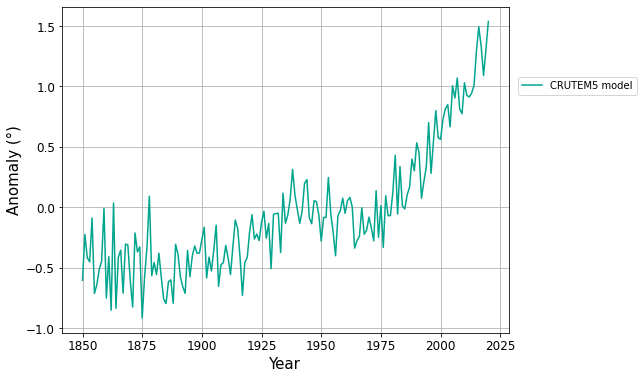

In [34]:
plt.figure(figsize = (8,6))

p1, = plt.plot(time_series.year, time_series, color = "#00A58E", ls = "-")


plt.legend([p1], ["CRUTEM5 model"], bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()